## Simple EC tests
The purpose here is to use the EC class of agnpy to calculate simple case which can be compared with back of the envelope calculations

In [1]:
# load all the necessary libraries
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import Distance
import matplotlib.pyplot as plt
import copy
import sys
sys.path.append("../../")
# import agnpy classes
from agnpy.emission_regions import Blob
from agnpy.compton import ExternalCompton
from agnpy.targets import SSDisk, SphericalShellBLR, RingDustTorus

In [2]:
import agnpy
agnpy.__file__

'/home/jsitarek/anaconda3/envs/agnpy/lib/python3.7/site-packages/agnpy/__init__.py'

In [3]:
# matplotlib adjustments and axes labels
plt.rc("figure", figsize=(7.5, 5.5))
plt.rc("font", size=12)
plt.rc("axes", grid=True)
plt.rc("grid", ls=":")
sed_x_label = r"$\nu\,/\,Hz$"
sed_y_label = r"$\nu F_{\nu}\,/\,(\mathrm{erg}\,\mathrm{cm}^{-2}\,\mathrm{s}^{-1})$"

### test 1
check consistency of EC on BLR with EC on DT

In [4]:
# blob1 with some reasonable parameters
norm1 = 1.5e5 * u.Unit("cm-3")
parameters1 = {
    "p1": 2.0,
    "p2": 3.9,
    "gamma_b": 300.,
    "gamma_min": 2.5,
    "gamma_max": 3.e4,
}
spectrum_dict = {"type": "BrokenPowerLaw", "parameters": parameters1}
R_b = 1.e16 * u.cm
B = 1. * u.G
z = 0.01
delta_D = 20
Gamma = 17
blob1 = Blob(R_b, z, delta_D, Gamma, B, norm1, spectrum_dict)
blob1.set_gamma_size(500)
#print(f"total number {blob_in.N_e_tot:.2e}")
#print(f"total energy {blob_in.W_e:.2e}")
print(blob1)

* spherical emission region
 - R_b (radius of the blob): 1.00e+16 cm
 - V_b (volume of the blob): 4.19e+48 cm3
 - z (source redshift): 0.01
 - d_L (source luminosity distance):1.38e+26 cm
 - delta_D (blob Doppler factor): 2.00e+01
 - Gamma (blob Lorentz factor): 1.70e+01
 - Beta (blob relativistic velocity): 9.98e-01
 - theta_s (jet viewing angle): 2.82e+00 deg
 - B (magnetic field tangled to the jet): 1.00e+00 G
 - xi (coefficient for 1st order Fermi acceleration) : 1.00e+00
* electron spectrum
 - broken power law
 - k_e: 4.18e+00 1 / cm3
 - p1: 2.00
 - p2: 3.90
 - gamma_b: 3.00e+02
 - gamma_min: 2.50e+00
 - gamma_max: 3.00e+04



In [5]:
### EC starts here, first the disk luminosity, 
L_disk = 1 * 1e45 * u.Unit("erg s-1")

# define radiation field
dist_in=0.2e17 * u.cm # location of the emission region
dist_rad = 1e18 * u.cm # location of the radiation field (>> dist_in)
xi = 0.5

#now make a BLR 
#blr = SphericalShellBLR(disk, xi, epsilon_dt, dist_rad)
blr = SphericalShellBLR(L_disk, xi, "Lyalpha", dist_rad)

In [6]:
epsil=blr.epsilon_line # line energy in in m_e c^2 
print(epsil)

# here define the DT
#T_dt = 1e3 * u.K
T_dt=(epsil/(2.7 * const.k_B) *  (const.m_e * const.c * const.c)).to("K")
print(T_dt)
# peak of the BB emission 
#epsilon_dt = 2.7 * ((const.k_B * T_dt) / (const.m_e * const.c * const.c)).decompose()
dt = RingDustTorus(L_disk, xi, T_dt, R_dt=dist_rad)

# DT will give nearly the same (except of angles) radiation field as BLR

1.9958625603026246e-05
43834.29096724084 K


In [7]:
# define the array of frequencies over which to calculate the SED 
nu1 = np.logspace(15, 30) * u.Hz
ec_blr1 = ExternalCompton(blob1, blr, r=dist_in)
ec_dt1 = ExternalCompton(blob1, dt, dist_in)
# compute the SEDs
ec_dt1_sed = ec_dt1.sed_flux(nu1)
ec_blr1_sed = ec_blr1.sed_flux(nu1)

7.41355501623236e+25 Hz
DT u_ph = 0.0013266786932417394 erg / cm3 , BLR u_ph =  [0.00132739] erg / cm3 , ratio =  [0.99946642]


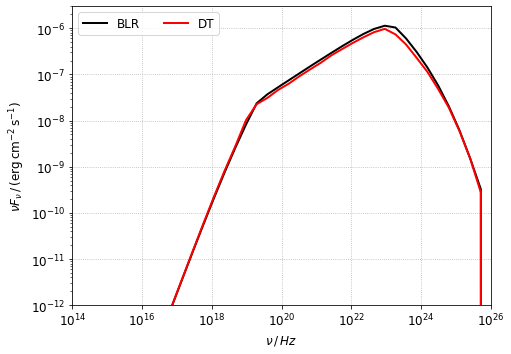

In [10]:
# maximum electron energies:
print((parameters1['gamma_max']*delta_D*511.e3*u.eV/const.h).to("Hz"))


dt_u_ph=dt.u(dist_in)
blr_u_ph=blr.u(dist_in)

print("DT u_ph =", dt_u_ph, ", BLR u_ph = ", blr_u_ph, ", ratio = ", dt_u_ph/blr_u_ph)

plt.loglog(nu1, ec_blr1_sed, lw=2, ls='-', color="k", label="BLR")
plt.loglog(nu1, ec_dt1_sed, lw=2, ls='-', color="r", label="DT")

plt.ylim(1e-12, 3e-6)
plt.xlim(1e14, 1e26)
plt.xlabel(sed_x_label)
plt.ylabel(sed_y_label)
plt.legend(ncol=2)
plt.show()
# both curves are similar BLR is a bit broader probably because of the broader range of angles of the radiation
# radiation density also matches 

### test 2
check level of EC emission in the Thomson regime for a simple slow blob case (no beaming), comparing with back-of-the-envelope calculations.

In [11]:
# blob2 with mono-energetic electrons
norm2 = 1.e5 * u.Unit("cm-3")
parameters2 = {
    "p": 2.0,
    "gamma_min": 90.,
    "gamma_max": 110.,
}
spectrum_dict = {"type": "PowerLaw", "parameters": parameters2}
R_b = 1.e16 * u.cm
B = 1. * u.G
z = 0.01
delta_D = 1.02
Gamma = 1.01
blob2 = Blob(R_b, z, delta_D, Gamma, B, norm2, spectrum_dict)
blob2.set_gamma_size(500)
print(f"total number {blob2.N_e_tot:.2e}")
#print(f"total energy {blob2.W_e:.2e}")
print(blob2)

total number 4.20e+53
* spherical emission region
 - R_b (radius of the blob): 1.00e+16 cm
 - V_b (volume of the blob): 4.19e+48 cm3
 - z (source redshift): 0.01
 - d_L (source luminosity distance):1.38e+26 cm
 - delta_D (blob Doppler factor): 1.02e+00
 - Gamma (blob Lorentz factor): 1.01e+00
 - Beta (blob relativistic velocity): 1.40e-01
 - theta_s (jet viewing angle): 7.79e+01 deg
 - B (magnetic field tangled to the jet): 1.00e+00 G
 - xi (coefficient for 1st order Fermi acceleration) : 1.00e+00
* electron spectrum
 - power law
 - k_e: 4.96e+07 1 / cm3
 - p: 2.00
 - gamma_min: 9.00e+01
 - gamma_max: 1.10e+02



In [12]:
dist_in=0.2e17 * u.cm # location of the emission region
dist_rad = 1e18 * u.cm # location of the radiation field (>> dist_in)

# we only consider DT here (the calculation are simpler and faster)
T_dt = 1e3 * u.K
# peak of the BB emission 
xi = 0.5
dt2 = RingDustTorus(L_disk, xi, T_dt, R_dt=dist_rad)

In [13]:
nu2 = np.logspace(15, 25,200) * u.Hz
ec_dt2 = ExternalCompton(blob2, dt2, dist_in)
ec_dt2_sed = ec_dt2.sed_flux(nu2)

In [14]:
# very simple trapesoid integration of SED to get absolute flux
def integrate_flux(nu, sed):
    flux=0
    dnu=nu[1:]-nu[:-1] # difference to next one
    dNdE=sed/(nu*nu*const.h)
    dN = 0.5*(dNdE[:-1]+dNdE[1:]) * dnu
    return np.sum(dN.to("cm-2 s-1"))

In [15]:
# now calculate the emission by hand. we have soft photons with energy epsilon_dt, and no beaming 
epsilon2 = 2.7 * ((const.k_B * T_dt) / (const.m_e * const.c * const.c)).decompose()

mec2=(const.m_e*const.c**2).to("eV") 
gamma=np.sqrt(parameters2['gamma_max'] * parameters2['gamma_min'])
Ee=gamma * mec2 # electron energy
Eg=epsilon2*mec2*gamma**2 # photons coming from the side and no beaming, so just gamma^2 times epsilon
# check Blumenthal & Gould 1970, eq 2.8 and 2.6
print("Ee=",Ee, "Eg=",Eg)
print("Eg/Ee=", Eg/Ee)
# we are far in the Thomson region
#(parameters1['gamma_max']*delta_D*511.e3*u.eV/const.h).to("Hz")

Ee= 50843753.562085725 eV Eg= 2303.4131809714063 eV
Eg/Ee= 4.53037594511721e-05


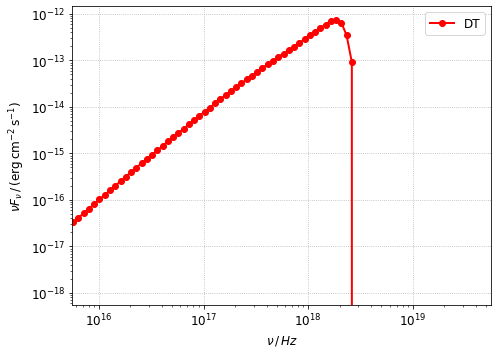

In [16]:
plt.loglog(nu2, ec_dt2_sed, lw=2, ls='-', marker='o', color="r", label="DT")

#plt.ylim(1e-13, 1e-2)
nug2=(Eg/const.h).to("Hz")
plt.xlim(nug2.value/100, nug2.value*100)
plt.xlabel(sed_x_label)
plt.ylabel(sed_y_label)
plt.legend(ncol=2)
plt.show()

In [17]:
# get the maximum of obtained SED
sedmax_obt=np.amax(ec_dt2_sed)
numax_obt=nu2[np.where(ec_dt2_sed==sedmax_obt)]
print("maximum of",sedmax_obt, "at",numax_obt)

numax_exp=(Eg/const.h).to("Hz")
print("Expected peak at: ",numax_exp)

print("peak position obtained / expected: ", numax_obt/numax_exp)

# the computed peak is at factor 3.3 higher value, 
# probably partially because it assumes that the photons are coming head-head 
# (which will be the case when there is some actual beaming), but this gives a factor 2, 
# remaining factor of 1.6 from some other simplifications ?? 

maximum of 7.492648086626283e-13 erg / (cm2 s) at [1.84642494e+18] Hz
Expected peak at:  5.5696282916654605e+17 Hz
peak position obtained / expected:  [3.31516727]


In [19]:
# now check the absolute level of flux from the (number) flux of photons from the obtained SED, 
# rough estimation dividing SED by peak energy 
#flux_obt = (sedmax_obt/ (numax_obt*const.h)).to("cm-2 s-1")
# a proper integral
flux_obt=integrate_flux(nu2, ec_dt2_sed)
print("observed flux of photons = ",flux_obt)

# first calculate the number density of soft photons in blob
# L_d *xi /epsilon of photons is sent per unit of time, 
# now just divide it by 4pi dist^2 to get the flux 
# and by c to convert to number density 
nsoft=L_disk*dt2.xi_dt/(dt2.epsilon_dt*mec2.to("erg")) / (4*np.pi*dt2.R_dt**2*const.c.to("cm s-1"))

# compute the same using a function in the class:
nsoft_class = dt.u(dist_in)/(dt2.epsilon_dt*mec2.to("erg"))
print("Nsoft =",nsoft, "Nsoft from dt.u_ph=", nsoft_class)
print("Nsoft obtained / Nsoft expected = ",nsoft_class/nsoft)

# each electron produces sigma_T*nsoft*c photons per second (no angular dependence since photons coming from the side)
# then we need to multiply it by number of electrons in the blob
# and divide it by 4 pi d_L^2

flux_exp=const.sigma_T.to("cm2")*nsoft*const.c.to("cm s-1") * blob2.N_e_tot / (4*np.pi*blob2.d_L**2)
print("flux expected = ",flux_exp)

print("flux obtained / expected: ", flux_obt/flux_exp)
# difference of a factor 2, and it should be independent of the previous difference of the peak position
# it comes already in the density of the soft photons

observed flux of photons =  0.00012450556167777345 1 / (cm2 s)
Nsoft = 3560347517.5081673 1 / cm3 Nsoft from dt.u_ph= 3558923947.9289956 1 / cm3
Nsoft obtained / Nsoft expected =  0.9996001599360256
flux expected =  0.0001249142806841723 1 / (cm2 s)
flux obtained / expected:  0.9967280041628528


### test 3
like test 2, but deep in Klein-Nishina regime, still no beaming!

In [20]:
# blob3 with mono-energetic electrons
norm3 = 1.e5 * u.Unit("cm-3")
parameters3 = {
    "p": 2.0,
    "gamma_min": 0.9e6,
    "gamma_max": 1.1e6,
}
spectrum_dict = {"type": "PowerLaw", "parameters": parameters3}
R_b = 1.e16 * u.cm
B = 1. * u.G
z = 0.01
delta_D = 1.02
Gamma = 1.01
blob3 = Blob(R_b, z, delta_D, Gamma, B, norm3, spectrum_dict)
blob3.set_gamma_size(500)
print(blob3)

* spherical emission region
 - R_b (radius of the blob): 1.00e+16 cm
 - V_b (volume of the blob): 4.19e+48 cm3
 - z (source redshift): 0.01
 - d_L (source luminosity distance):1.38e+26 cm
 - delta_D (blob Doppler factor): 1.02e+00
 - Gamma (blob Lorentz factor): 1.01e+00
 - Beta (blob relativistic velocity): 1.40e-01
 - theta_s (jet viewing angle): 7.79e+01 deg
 - B (magnetic field tangled to the jet): 1.00e+00 G
 - xi (coefficient for 1st order Fermi acceleration) : 1.00e+00
* electron spectrum
 - power law
 - k_e: 4.96e+11 1 / cm3
 - p: 2.00
 - gamma_min: 9.00e+05
 - gamma_max: 1.10e+06



In [21]:
# reuse the same disk 
dist_in=0.2e17 * u.cm # location of the emission region
dist_rad = 1e18 * u.cm # location of the radiation field (>> dist_in)

# 100 times larger temperature for the test
T_dt = 1e3 * u.K * 100
# peak of the BB emission 
epsilon3 = 2.7 * ((const.k_B * T_dt) / (const.m_e * const.c * const.c)).decompose()
xi = 0.5
dt3 = RingDustTorus(L_disk, xi, T_dt, R_dt=dist_rad)

In [22]:
nu3 = np.logspace(20, 30,200) * u.Hz
ec_dt3 = ExternalCompton(blob3, dt3, dist_in)
ec_dt3_sed = ec_dt3.sed_flux(nu3)

In [23]:
# now calculate the emission by hand. we have soft photons with energy epsilon_dt, and no beaming  
gamma=np.sqrt(parameters3['gamma_max'] * parameters3['gamma_min'])
Ee=gamma * mec2 # electron energy
Eg=epsilon3*mec2*gamma**2 # photons coming from the side and no beaming, so just gamma^2 times epsilon
print("Ee=",Ee, "Eg=",Eg)
print("Eg/Ee=", Eg/Ee)
# we are far in the K-N region, so in fact Eg~Ee now
nug3=(gamma*mec2/const.h).to("Hz")
print(nug3)

Ee= 508437535620.85724 eV Eg= 23034131809714.066 eV
Eg/Ee= 45.303759451172105
1.2293964914034002e+26 Hz


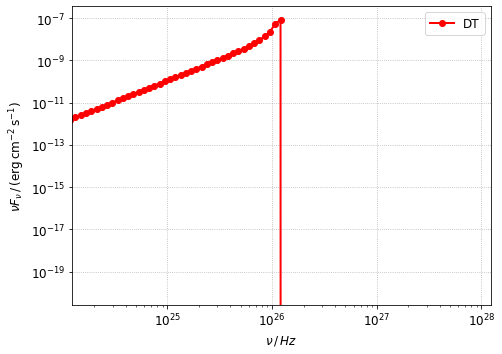

In [24]:
plt.loglog(nu3, ec_dt3_sed, lw=2, ls='-', marker='o', color="r", label="DT")

#plt.ylim(1e-13, 1e-2)
plt.xlim(nug3.value/100, nug3.value*100)
plt.xlabel(sed_x_label)
plt.ylabel(sed_y_label)
plt.legend(ncol=2)
plt.show()

In [25]:
# get the maximum of obtained SED
sedmax_obt=np.amax(ec_dt3_sed)
numax_obt=nu3[np.where(ec_dt3_sed==sedmax_obt)]
print("maximum of",sedmax_obt, "at",numax_obt)

print("Expected peak at: ",nug3)

print("peak position obtained / expected: ", numax_obt/nug3)

# this agrees nicely, in KN you are limitted by the energy of electrons

maximum of 8.230011837483587e-08 erg / (cm2 s) at [1.20337784e+26] Hz
Expected peak at:  1.2293964914034002e+26 Hz
peak position obtained / expected:  [0.97883624]


In [26]:
# now check the absolute level of flux from the (number) flux of photons from the obtained SED, 
# rough estimation dividing SED by peak energy 
#flux_obt = (sedmax_obt/ (numax_obt*const.h)).to("cm-2 s-1")
# a proper integral
flux_obt=integrate_flux(nu3, ec_dt3_sed)
print("observed flux of photons = ",flux_obt)

# first calculate the number density of soft photons in blob
# L_d *xi /epsilon of photons is sent per unit of time, 
# now just divide it by 4pi dist^2 to get the flux 
# and by c to convert to number density 
nsoft=L_disk*dt3.xi_dt/(dt3.epsilon_dt*mec2.to("erg")) / (4*np.pi*dt3.R_dt**2*const.c.to("cm s-1"))

# same using the class 
nsoft_class = dt3.u(dist_in)/(dt3.epsilon_dt*mec2.to("erg"))
print("Nsoft =",nsoft, ", Nsoft from dt.u_ph=", nsoft_class, ", predicted to simulated=",nsoft/nsoft_class)


#
w=gamma*epsilon3 
print("Scattered photon energy in m_e units in electron frame:",w)
# correction for KN effect
KN = 0.75 * ((1+w)*(2*w*(1+w)/(1+2*w)-np.log(1+2*w))/np.power(w,3) + np.log(1+2*w)/(2*w) - (1+3*w)/np.power(1+2*w,2));
print(KN)
# calculated the same way as in Test 2, but with additional correction for KN effect
flux_exp=KN*const.sigma_T.to("cm2")*nsoft*const.c.to("cm s-1") * blob3.N_e_tot / (4*np.pi*blob3.d_L**2)
print("flux expected = ",flux_exp)

print("flux obtained / expected: ", flux_obt/flux_exp)

observed flux of photons =  4.280288179953388e-08 1 / (cm2 s)
Nsoft = 35603475.17508168 1 / cm3 , Nsoft from dt.u_ph= 35589239.47928996 1 / cm3 , predicted to simulated= 1.0004000000000002
Scattered photon energy in m_e units in electron frame: 45.303759451172105
0.04057537761110685
flux expected =  5.066891675379446e-08 1 / (cm2 s)
flux obtained / expected:  0.8447562044303718


## test 4
like test 2(EC in Thomson range on DT photons), but with beaming 

In [27]:
# make a copy of blob2, but set a higher beaming
blob4=copy.deepcopy(blob2)
blob4.set_delta_D(10,0.05*u.rad)
delta4=blob4.delta_D
print(delta4)


ec_dt4 = ExternalCompton(blob4, dt2, dist_in)
ec_dt4_sed = ec_dt4.sed_flux(nu2)

15.984557382940189


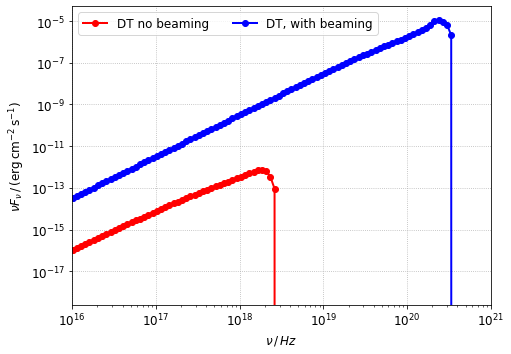

In [28]:
plt.loglog(nu2, ec_dt2_sed, lw=2, ls='-', marker='o', color="r", label="DT no beaming")
plt.loglog(nu2, ec_dt4_sed, lw=2, ls='-', marker='o', color="b", label="DT, with beaming")

#plt.ylim(1e-13, 1e-2)
plt.xlim(1.e16, 1.e21)
plt.xlabel(sed_x_label)
plt.ylabel(sed_y_label)
plt.legend(ncol=2)
plt.show()

In [29]:
# get the maximum of obtained SED
sedmax_obt=np.amax(ec_dt4_sed)
numax_obt=nu2[np.where(ec_dt4_sed==sedmax_obt)]
print("maximum of",sedmax_obt, "at",numax_obt)

# in the frame of the BH, radiation field is almost perpendicular do the blob direction
# so the doppler factor 1/(Gamma +beta*mu') is ~ Gamma
doppler_dt=blob4.Gamma

epsilon4=dt2.epsilon_dt*mec2 * doppler_dt # energy of DT photons in the frame of the jet
# in frame of the blob photons are coming head-head (hence *2) 
# and then boosted back to observer's frame with blob's doppler factor 
gamma=np.sqrt(parameters2['gamma_max'] * parameters2['gamma_min'])
Eg=epsilon4 * 2 * gamma**2 * blob4.delta_D 
numax_exp=(Eg/const.h).to("Hz")
print("Expected peak at: ",numax_exp)

print("peak position obtained / expected: ", numax_obt/numax_exp)

# in the slow blob case we had a difference of ~3.3, out of which a factor ~2 could be understood 
# as a simplification for fast blobs, so we had ~1.6 left. Here we get even closer value ~1.3
# again, maybe there are more simplifications that fail in the case of slow blob, but still work for fast ones? 
# or there are two mistakes that nearly cancel each other :-)

maximum of 1.1514483946118636e-05 erg / (cm2 s) at [2.38168555e+20] Hz
Expected peak at:  1.780560860595474e+20 Hz
peak position obtained / expected:  [1.33760413]


In [31]:
# now check the absolute level of flux from the (number) flux of photons from the obtained SED, 
# rough estimation dividing SED by peak energy 
#flux_obt = (sedmax_obt/ (numax_obt*const.h)).to("cm-2 s-1")
# a proper integral
flux_obt=integrate_flux(nu2, ec_dt4_sed)
print("observed flux of photons = ",flux_obt)

# first calculate the number density of soft photons in blob
# first without beaming
# L_d *xi /epsilon of photons is sent per unit of time, 
# now just divide it by 4pi dist^2 to get the flux 
# and by c to convert to number density 
nsoft=L_disk*dt2.xi_dt/(dt2.epsilon_dt*mec2.to("erg")) / (4*np.pi*dt2.R_dt**2*const.c.to("cm s-1"))
# energy density would scale as doppler_dt^3 
# beaming for a perpendicular case will boost the number density by Gamma (just the transformation of volume) 
# note that the energy density of isotropic radiation is upscaled by ~Gamma^2 
#( eq 10 in https://iopscience.iop.org/article/10.1086/341431), and this includes upscaling of energy by ~doppler_dt
nsoft*=blob4.Gamma
print("Nsoft =",nsoft)

# each electron produces 2*sigma_T*nsoft*c photons per second 
# (because of beaming photons coming head-head in the blob's frame)
# then we need to multiply it by number of electrons in the blob
# and divide it by 4 pi d_L^2
#first without beaming
flux_exp=2* const.sigma_T.to("cm2")*nsoft*const.c.to("cm s-1") * blob2.N_e_tot / (4*np.pi*blob2.d_L**2)
# and now beaming will increase the flux of photons by blob's D to the power of 3 (2 from the angles, 1 from the time)
flux_exp*=blob4.delta_D**3
print("flux expected = ",flux_exp)

print("flux obtained / expected: ", flux_obt/flux_exp)

observed flux of photons =  8.872086565925649 1 / (cm2 s)
Nsoft = 35603475175.08167 1 / cm3
flux expected =  10.203376969500145 1 / (cm2 s)
flux obtained / expected:  0.869524530206619
